# 2D-CNNs for MNIST dataset
* Learn about:
    * [THE MNIST DATABASE](http://yann.lecun.com/exdb/mnist/)
    * Coding with PyTorch Lightning
        * LightningDataModule
        * LightningModule
        * (optional) Logger, Trainer, callbacks
    * Two types of the artificial neuralnetworks
        * Multilayer perceptron (MLP)
        * 2D Convolutional neuralnetworks (2D CNNs)
* Let's try:
    * Build MLP or CNNs by yourself
    * Try to use other loss functions
    * Try to change the training parameters
        * learning rate, batch size, epochs, etc...

## Step1. Lightning data module for MNIST dataset ##

* `train_data`: 50,000
* `test_data`: 10,000
* `val_data`: 10,000

In [64]:
import os
import torch
from torch.utils.data import Dataset
import numpy as np

from pytorch_lightning import LightningDataModule
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision import transforms
from typing import Optional



In [65]:
print(torch.cuda.is_available())

True


In [ ]:
class HKDataset(LightningDataModule):
    def __init__(
        self,
        batch_size: int = 128,
        num_workers: int = 2,
        ):
        super().__init__()

        self.batch_size = batch_size
        self.num_workers = num_workers
        self.mean = ()
        self.std = ()
        self.trans = None

    def setup(self, stage: Optional[str] = None) -> None:
        imgs = torch.load('/home/edward/HK_Project/hyperk_img/imgs_scaled.pt')
        labels_targets = torch.load('/home/edward/HK_Project/hyperk_img/labels_targets_scaled.pt')
        indices = torch.load('/home/edward/HK_Project/hyperk_img/indices.pt')

        self.train_data = torch.utils.data.TensorDataset( imgs[indices['train']], labels_targets[indices['train']])
        self.valid_data = torch.utils.data.TensorDataset( imgs[indices['valid']], labels_targets[indices['valid']])
        self.test_data = torch.utils.data.TensorDataset( imgs[indices['test']], labels_targets[indices['test']])

    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.valid_data, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size=self.batch_size, num_workers=self.num_workers)
    

## Step2-2. 2D-CNNs model ##

In [ ]:
from torch import nn
import torch
import torch.nn as nn
import torch.nn.functional as F

class SpatialTransformerNetwork(nn.Module):
    def __init__(self, input_size, num_channels):
        super(SpatialTransformerNetwork, self).__init__()
        
        
        self.localization = nn.Sequential(
            nn.Conv2d(num_channels, 8, kernel_size=7),  
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),                 
            nn.Conv2d(8, 10, kernel_size=5),           
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),                 
        )
        
        
        self.fc_loc = nn.Sequential(
            nn.Linear(1440, 32),  
            nn.ReLU(),
            nn.Linear(32, 6)  
        )
        
        
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
    
    def forward(self, x):
        
        batch_size = x.size(0)
        xs = self.localization(x)
        xs = xs.view(batch_size, -1)  
        theta = self.fc_loc(xs)  
        theta = theta.view(-1, 2, 3)  
        
        
        grid = F.affine_grid(theta, x.size(), align_corners=False)
        x = F.grid_sample(x, grid, align_corners=False)
        return x



class CNNs2D(nn.Module):
    def __init__(self):
        super(CNNs2D, self).__init__()
        
        self.stn = SpatialTransformerNetwork(input_size=(64, 64), num_channels=2) 
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=32, kernel_size=2, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 2, 2, 2, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 2, 2, 2, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )

        self.fc_layer = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128), 
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),   
            nn.ReLU(inplace=True),
        )

        self.fc_layer_cap = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128), 
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),   
            nn.ReLU(inplace=True),
        )

        

        self.fc_class_layer = nn.Sequential(
            nn.Linear(192,64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 2),     
            nn.Softmax(dim=1)
        )
        self.fc_regression_layer = nn.Sequential(
            nn.Linear(192,64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 4),    
            nn.Tanh()
        )
    def forward(self, x):
        x = self.stn(x)
        #print('x0', x.shape)
        region1 = x[:, :, 0:20, 21:42]
        region2 = x[:, :, 21:43, :]
        region3 = x[:, :, 44:64, 21:42]
        
        def process_barrel_region(region):
            
            region = self.conv1(region)
            region = self.conv2(region)
            region = self.conv3(region)
            region = region.view(region.size(0), -1)
            return self.fc_layer(region)
        
        def process_cap_region(region):
            
            region = self.conv1(region)
            region = self.conv2(region)
            region = self.conv3(region)
            region = region.view(region.size(0), -1)
            return self.fc_layer_cap(region)

        r1 = process_cap_region(region1)
        r2 = process_barrel_region(region2)
        r3 = process_cap_region(region3)
        x = torch.cat((r1, r2, r3), dim=1)
        
        #print('x4', x.shape, x)
        return [self.fc_class_layer(x), self.fc_regression_layer(x)]
    
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(pred+1), torch.log(actual+1)))
    
def rse_loss(pred, target):
        return torch.sqrt(torch.sum((pred-target)**2)/torch.sum((target-torch.mean(target))**2))
    

## Step3. Pytorch lightning module ##

In [69]:
from torch.nn import functional as F
from torch import optim
from torch import Tensor
from torchmetrics.classification import BinaryAccuracy
from pytorch_lightning import LightningModule

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma = 5):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce_loss = nn.CrossEntropyLoss(reduction = 'none')

    def forward(self, inputs, targets):
        ce_loss = self.ce_loss(inputs, targets)
        p_t = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-p_t)**self.gamma*ce_loss
        return focal_loss.mean()

class PLModuleMNIST(LightningModule):
    def __init__(self, model, lr_rate):
        super(PLModuleMNIST, self).__init__()
        self.model = model
        self.lr_rate = lr_rate
        self.accuracy_calc = BinaryAccuracy(threshold=0.5)
        self.focal_loss = FocalLoss(alpha = 0.25, gamma = 4.5)
        self.automatic_optimization = False
        self.loss_training = []
        self.loss_valid = []
        self.loss_training_epoch = []
        self.loss_valid_epoch = []
        
        self.acc_training = []
        self.acc_valid = []
        self.acc_training_epoch = []
        self.acc_valid_epoch = []

    def forward(self, batch: Tensor, **kwargs) -> Tensor:
        #print('batch:', batch.size)
        return self.model(batch)

    #def loss_fn(self, x, y):
    #    #print('loss:x,y',x.shape, y.shape)
    #    #print('type',x[0].dtype, y[0].dtype)
    #    return F.nll_loss(x, y)
    
    #def loss_fn_regression(self, x, y):
    #    #print(x[0][0], y[0][0])
    #    loss_energy = F.l1_loss(x[:,0], y[:,0])
    #    loss_position = F.l1_loss(x[:,1:4], y[:,1:4])
    #    loss = loss_energy + loss_position
    #    return loss


    def loss_fn(self, x, y):
        x_class=x[0]
        y_class=torch.tensor(y[:,0], dtype=torch.int64)
        
        #print(y)
        x_reg=x[1]
        y_reg=y[:,1:]
        
        loss_class = self.focal_loss(x_class, y_class)
        loss_energy = rse_loss(x_reg[:,0], y_reg[:,0])
        loss_position = rse_loss(x_reg[:,1:4], y_reg[:,1:4])
        loss = loss_class + loss_energy + loss_position
        
        return loss

    def training_step(self, batch):
        opt = self.optimizers()
        opt.zero_grad()
        
        x, y = batch
        label=torch.tensor(y[:,0], dtype=torch.int64)
        #targets=y[:,1:5]
        
        logits = self.forward(x)
        loss = self.loss_fn(logits,y)
        #loss = self.loss_fn(logits,y[:,0])
        #loss = self.loss_fn_regression(logits,targets)
        
        acc = self.accuracy_calc(logits[0][:,1], label)
        
        self.manual_backward(loss)
        opt.step()

        self.loss_training.append(loss)
        self.acc_training.append(acc)        

        
    def validation_step(self, batch):
        x, y = batch
        
        label=torch.tensor(y[:,0], dtype=torch.int64)
        #targets=y[:,1:5]
        #print('val:x,y', x.shape, y.shape)
        #print('type',type(x), type(y))
        logits = self.forward(x)
        loss = self.loss_fn(logits,y)
        acc = self.accuracy_calc(logits[0][:,1], label)
        #loss = self.loss_fn(logits,y[:,0])
        #loss = self.loss_fn_regression(logits,targets)
        #acc = self.accuracy_calc(logits, y[:,0])
        self.loss_valid.append(loss)
        self.acc_valid.append(acc)

    
    def test_step(self, batch):
        x, y = batch
        label=torch.tensor(y[:,0], dtype=torch.int64)
        #targets=y[:,1:5]
        logits = self.forward(x)
        loss = self.loss_fn(logits,y)
        acc = self.accuracy_calc(x[1], label)
        
        #loss = self.loss_fn(logits,y[:,0])
        #loss = self.loss_fn_regression(logits,targets)
        #acc = self.accuracy_calc(logits, y[:,0])

    
    def on_train_epoch_end(self) -> None:
        avg_loss = torch.stack(self.loss_training).mean()
        avg_acc = torch.stack(self.acc_training).mean()
        self.loss_training.clear()
        self.acc_training.clear()
        #print('train_loss:', avg_loss, 'train_acc', avg_acc)
        self.loss_training_epoch.append(avg_loss)
        self.acc_training_epoch.append(avg_acc)
        self.log('loss/train',avg_loss)
        self.log('acc/train',avg_acc)

    def on_validation_epoch_end(self) -> None:
        avg_loss = torch.stack(self.loss_valid).mean()
        avg_acc = torch.stack(self.acc_valid).mean()
        self.loss_valid.clear()
        self.acc_valid.clear()
        self.loss_valid_epoch.append(avg_loss)
        self.acc_valid_epoch.append(avg_acc)
        self.log('loss/valid',avg_loss)
        self.log('acc/valid',avg_acc)


    def configure_optimizers(self):
        optimizer =  optim.Adam(self.parameters(), lr=self.lr_rate, weight_decay = 1e-4)
        lr_scheduler = {'scheduler': optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9), 'name': 'exp_LR'}
        return [optimizer], [lr_scheduler]
        #return optim.Adam(self.model.parameters(), lr=0.001)

## Step4. Logger ##
Tensorboard logger is used. A window of tensorboard opens here.

In [70]:
from pytorch_lightning.loggers import TensorBoardLogger

logger = TensorBoardLogger(save_dir='./tb_logs/', name = 'HK')


#%reload_ext tensorboard
#%tensorboard --logdir=./tb_logs/

## Step5. Build & fit a model ##
Select whether to use `MLP()` or `CNNs2D()` for the model. The settings for the learning is described here.
* `lr_rate`: learning rate
* `batch_size`
* `max_epochs`

In [71]:
model_core = CNNs2D() # or MLP()
#model_core = MLP()
model = PLModuleMNIST(model = model_core, lr_rate=0.002)
dm = HKDataset(batch_size=512)

In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.progress import TQDMProgressBar

runner = Trainer(max_epochs=100, 
                 #gpus=[0],
                 accelerator='cpu',  # or 'gpu', 'auto'
                 devices = 1,
                 logger=logger, 
                 callbacks=[TQDMProgressBar(refresh_rate=10)])


runner.fit(model, dm)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type           | Params | Mode 
---------------------------------------------------------
0 | model         | CNNs2D         | 317 K  | train
1 | accuracy_calc | BinaryAccuracy | 0      | train
2 | focal_loss    | FocalLoss      | 0      | train
---------------------------------------------------------
317 K     Trainable params
0         Non-trainable params
317 K     Total params
1.270     Total estimated model params size (MB)
61        Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/tmp/ipykernel_791901/1075227814.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label=torch.tensor(y[:,0], dtype=torch.int64)
/tmp/ipykernel_791901/1075227814.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_class=torch.tensor(y[:,0], dtype=torch.int64)


/home/edward/.venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0:   0%|          | 0/20 [00:00<?, ?it/s] 

/tmp/ipykernel_791901/1075227814.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label=torch.tensor(y[:,0], dtype=torch.int64)


Epoch 199: 100%|██████████| 20/20 [00:01<00:00, 12.55it/s, v_num=132]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 20/20 [00:01<00:00, 12.15it/s, v_num=132]


## Step6. Check the trained model ##
* Structure of the model
* Classification performance for the test dataset
* Feature maps

#### Step6-1. Structure of the trained model ####

In [73]:
## You can load the trained model at the specific checkpoint
#model = PLModuleMNIST.load_from_checkpoint(model=model_core, lr_rate=0.001, checkpoint_path='tb_logs/HK/version_30/checkpoints/epoch=468-step=37051.ckpt')
print(model)

PLModuleMNIST(
  (model): CNNs2D(
    (stn): SpatialTransformerNetwork(
      (localization): Sequential(
        (0): Conv2d(2, 8, kernel_size=(7, 7), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): Conv2d(8, 10, kernel_size=(5, 5), stride=(1, 1))
        (4): ReLU()
        (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (fc_loc): Sequential(
        (0): Linear(in_features=1440, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=6, bias=True)
      )
    )
    (upconv1): ConvTranspose2d(2, 16, kernel_size=(2, 2), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
    (conv1): Sequential(
      (0): Conv2d(2, 32, kernel_size=(2, 2), stride=(2, 2), padding=(2, 2), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True

In [74]:
model.eval()
#dm.setup() # when you load the model from a checkpoint

labels_targets = []
#outputs = []
outputs_class = []
outputs_targets = []
for batch in dm.test_dataloader():
    x, y = batch 
    
    outputs = model.model(x)
    out_class = outputs[0].to('cpu').detach()
    out_targets =  outputs[1].to('cpu').detach()
    outputs_class.append(out_class)
    outputs_targets.append(out_targets)
    labels_targets.append(y.to('cpu').detach())
    

In [75]:
labels_targets=np.vstack(labels_targets)
outputs_class=np.vstack(outputs_class)
outputs_targets=np.vstack(outputs_targets)



In [76]:


#torch.save(labels_targets, 'test_labels_targets.pt')
#torch.save(outputs_class, 'test_outputs_class.pt')
#torch.save(outputs_targets, 'test_outputs_targets.pt')

#### Step6-2. Classification perfromance for the test dataset ####
`Loss` and `Accuracy` are useful metrics for understanding the performance

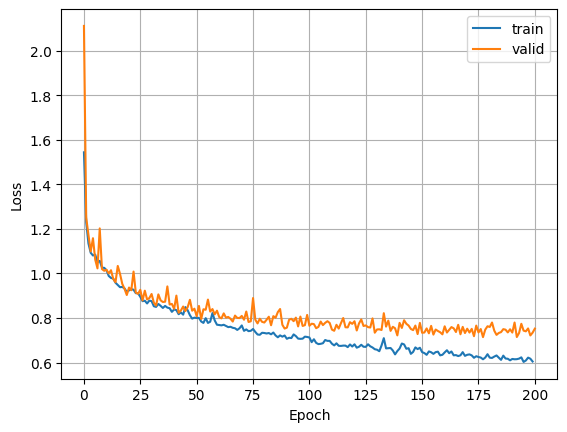

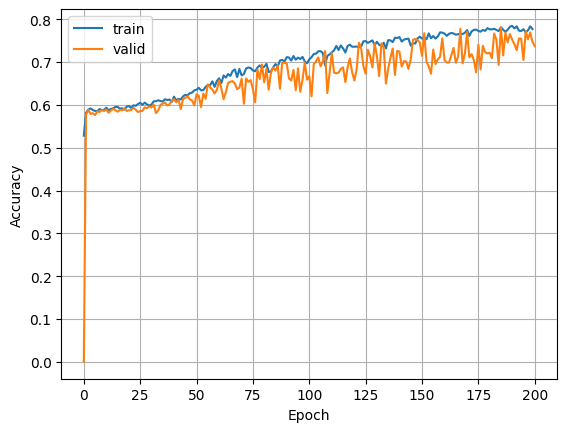

In [77]:
import matplotlib.pyplot as plt
loss_train = [i.to('cpu').detach().numpy() for i in model.loss_training_epoch]
loss_valid = [i.to('cpu').detach().numpy() for i in model.loss_valid_epoch]

plt.plot(loss_train, label='train')
plt.plot(loss_valid, label='valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
#plt.ylim([None, 1])
plt.show()


acc_train = [i.to('cpu').detach().numpy() for i in model.acc_training_epoch]
acc_valid = [i.to('cpu').detach().numpy() for i in model.acc_valid_epoch]

plt.plot(acc_train, label='train')
plt.plot(acc_valid, label='valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
#plt.ylim([None, 1])
plt.show()

In [78]:
torch.save(labels_targets, 'Sep_test_labels_targets.pt')
torch.save(outputs_class, 'Sep_test_outputs_class.pt')
torch.save(outputs_targets, 'Sep_test_outputs_targets.pt')